# Forest Fire

## “This model simulates the spread of a fire through a forest. It shows that the fire’s chance of reaching the right edge of the forest depends critically on the density of trees."

### First, we import the libraries

In [37]:
import agentpy as ap

#Others
import random
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

### Then, we create the class wich contains the setup method.
### In this method we create the agents, the forest and define the posible conditions in which a tree could be
### There are 5 possible conditions as state for the trees
## 0. Alive, 1: burn-low, 2: burn-mid, 3: burn-high and 4: totally burned
## In what condition a tree stays depends on how many neighbours are on fire around it

### On top of that, a randomizer start position was added so that in every iteration of the model we could start from a different position
### this positions are top, down, left and right

In [38]:
class ForestModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        n_trees = int(self.p['Tree density'] * (self.p.size**2))
        trees = self.agents = ap.AgentList(self, n_trees)

        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.forest.add_agents(trees, random=True, empty=True)
   
        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: burn-low, 2: burn-mid, 3: burn-high, 4: almost-burned 5: totally-burned
        self.agents.condition = 0
        
        self.random = random.randint(0,3)

        # Start a fire from the left side of the grid

        #Start from left side
        if self.random == 0:
            unfortunate_trees = self.forest.agents[0:self.p.size, 0:3]
        #Start from top side
        elif self.random == 1:
            unfortunate_trees = self.forest.agents[0:2, 0:self.p.size]
        #Start from right side
        elif self.random == 2:
            unfortunate_trees = self.forest.agents[0:self.p.size, 47:self.p.size]
        #Start from down side
        elif self.random == 3:
            unfortunate_trees = self.forest.agents[47:self.p.size, 0:self.p.size]

        unfortunate_trees.condition = 1

    def step(self):

        # Select burning trees
        burning_trees = self.agents.select(self.agents.condition == 1 or self.agents.condition == 2 or self.agents.condition == 3)

        # Spread fire
        for tree in burning_trees:
            for neighbor in self.forest.neighbors(tree):
                if neighbor.condition < 5:
                    neighbor.condition = neighbor.condition + 1 # Neighbor starts burning
        
            tree.condition = 5 # Tree burns out
                
            
                
                

        # Stop simulation if no fire is left
        if len(burning_trees) == 0:
            self.stop()

    def end(self):

        # Document a measure at the end of the simulation
        burned_trees = len(self.agents.select(self.agents.condition == 4 or self.agents.condition == 5))
        self.report('Percentage of burned trees',
                    burned_trees / len(self.agents))

## Here we defined the parameters of the model as of
### tree density, size and steps

In [39]:
# Define parameters

parameters = {
    'Tree density': 0.6, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 100,
}

### Now. we make a plot with the simulation of how all the trees were burned
### In this simulation we defined different color to represent each state of the tree
## The more red a tree is the more burned it is, if the tree is black it means is totally burned

In [40]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#B32A2A', 2:'#ffff00',3:'#DEBA09' ,4: '#DE8709', 5: '#ffffff', None:'#d5e5d5'}
    
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents.select(model.agents.condition == 0))}")

fig, ax = plt.subplots()
model = ForestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

In [41]:
# Prepare parameter sample
parameters = {
    'Tree density': ap.Range(0.2, 0.6),
    'size': 100
}
sample = ap.Sample(parameters, n=30)

### Then we perform an experiment to test many simulations

In [42]:
# Perform experiment
exp = ap.Experiment(ForestModel, sample, iterations=40)
results = exp.run()

Scheduled runs: 1200
Completed: 1200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:06:57.161091


In [43]:
# Save and load data
results.save()
results = ap.DataDict.load('ForestModel')

Data saved to ap_output/ForestModel_1
Loading from directory ap_output/ForestModel_1/
Loading reporters.csv - Successful
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_log.json - Successful
Loading parameters_sample.csv - Successful


## Finnaly, we plot the results of the simulation

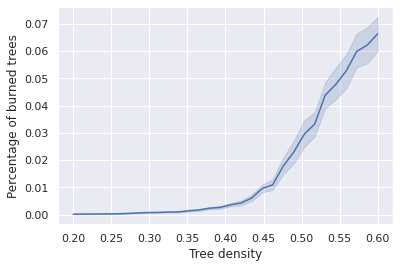

In [44]:
# Plot sensitivity
sns.set_theme()
sns.lineplot(
    data=results.arrange_reporters(),
    x='Tree density',
    y='Percentage of burned trees'
);